The original version of reconstruction script, from Kobe

With tip loss of the original frame, without contour loss of the original frame.

Without motion model loss.

In [1]:
'''
File used to run optimization on the catheter parameters. 
Uses Adam optimizer. 
'''
import sys
# from turtle import pd

sys.path.append('..')

# import os
import numpy as np

# import transforms
# import bezier_interspace_transforms
# sys.path.insert(1, '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')
# from bezier_set import BezierSet
# import camera_settings

import torch

# import open3d as o3d

import cv2
import matplotlib.pyplot as plt

# import pdb

from test_reconst_v2 import ConstructionBezier
# from blender_catheter import BlenderRenderCatheter
# from diff_render_catheter import DiffRenderCatheter
from test_loss_define_v2 import ChamferLossWholeImage, ContourChamferLoss, \
    TipChamferLoss, BoundaryPointChamferLoss, TipDistanceLoss, BoundaryPointDistanceLoss, \
    GenerateRefData

# import pytorch3d

import torch.nn as nn
# import torch.nn.functional as F

# import matplotlib.cm as colormap

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm


class CatheterOptimizeModel(nn.Module): 
    '''
    This class is used to optimize the catheter parameters.
    '''
    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, img_save_path): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        ###========================================================
        ### 1) SETTING UP BEZIER CURVE CONSTRUCTION
        ###========================================================
        self.build_bezier = ConstructionBezier()
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        ###========================================================
        ### 2) SETTING UP LOSS FUNCTIONS
        ###========================================================
        # self.chamfer_loss_whole_image = ChamferLossWholeImage(device=gpu_or_cpu)
        # self.chamfer_loss_whole_image.to(gpu_or_cpu)
        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        # self.tip_chamfer_loss = TipChamferLoss(device=gpu_or_cpu)
        # self.tip_chamfer_loss.to(gpu_or_cpu)
        # self.boundary_point_chamfer_loss = BoundaryPointChamferLoss(device=gpu_or_cpu)
        # self.boundary_point_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        # self.boundary_point_distance_loss = BoundaryPointDistanceLoss(device=gpu_or_cpu)
        # self.boundary_point_distance_loss.to(gpu_or_cpu)

        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None


        ###========================================================
        ### 3) SETTING UP CURVE PARAMETERS
        ###========================================================

        # Straight Line for initial parameters
        # self.para_init = nn.Parameter(torch.from_numpy(
        #     np.array([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866],
        #              dtype=np.float32)).to(gpu_or_cpu),
        #                               requires_grad=True)

        self.p_start = p_start.to(gpu_or_cpu).detach()

        # self.para_init = nn.Parameter(torch.from_numpy(
        #     np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
        #              dtype=np.float32)).to(gpu_or_cpu),
        #                               requires_grad=True)
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)

        

        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        
        self.gpu_or_cpu = gpu_or_cpu




    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # # Get 2d center line from reference image (using skeletonization)
        # centerline_ref = self.centerline_loss.get_raw_centerline(self.image_ref)
        # print("centerline_ref shape: ", centerline_ref.shape)
        # print("centerline_ref: ", centerline_ref)
        
        # # Plot the points in centerline_ref 
        # fig1, ax1 = plt.subplots()
        # ax1.plot(centerline_ref[:, 1], centerline_ref[:, 0])
        # ax1.set_title('centerline_ref')
        # ax1.set_xlim([0, 640])
        # ax1.set_ylim([480, 0])
        # plt.show()

        ###========================================================
        ### 1) RUNNING BEZIER CURVE CONSTRUCTION
        ###========================================================
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # cylinder_mesh_points = self.build_bezier.cylinder_mesh_points
        # print("cylinder_mesh_points max value: ", torch.max(cylinder_mesh_points))

        # TEST LOSS TO SEE IF DIFFERENTIABLE UP TILL THIS POINT
        # find average distance of all the points in cylinder_mesh_points to (0, 0, 0)
        # loss = torch.mean(torch.norm(cylinder_mesh_points, dim=1))

        # Plot 3D Bezier Cylinder mesh points
        # self.build_bezier.plot3dBezierCylinder()

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()


        # TEST LOSS TO SEE IF DIFFERENTIABLE UP TILL THIS POINT
        # find average distance of all the points in cylinder_mesh_points to (0, 0)
        # bezier_proj_img = self.build_bezier.bezier_proj_img
        # print("bezier_proj_img:" , bezier_proj_img)
        # print("Max value in bezier_proj_img: ", torch.max(bezier_proj_img))
        # print("average value in bezier_proj_img", torch.mean(bezier_proj_img))
        # loss = torch.mean(torch.norm(bezier_proj_img, dim=1))

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        # TEST LOSS TO SEE IF DIFFERENTIABLE UP TILL THIS POINT
        # find average distance of all points in bezier_proj_centerline_img to (0, 0)
        # bezier_proj_centerline_img = self.build_bezier.bezier_proj_centerline_img
        # loss = torch.mean(torch.norm(bezier_proj_centerline_img, dim=1))

        # Plot 2D projected Bezier Cylinder mesh points
        # print("cylinder_mesh_points: ", self.build_bezier.cylinder_mesh_points)
        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)

        # TODO: add function to save image to file

        ###========================================================
        ### 4) Compute Loss using various Loss Functions
        ###========================================================
        # loss_whole_image = self.chamfer_loss_whole_image(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_tip = self.tip_chamfer_loss(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_boundary = self.boundary_point_chamfer_loss(self.build_bezier.bezier_proj_img, self.image_ref)
        # loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img, self.image_ref)
        # loss_boundary_point_distance_loss = self.boundary_point_distance_loss(self.build_bezier.bezier_proj_img, self.image_ref)

        # loss_whole_image = self.chamfer_loss_whole_image(self.build_bezier.bezier_proj_img, self.image_ref)
        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(gpu_or_cpu))
        # loss_tip = self.tip_chamfer_loss(self.build_bezier.bezier_proj_img, self.ref_catheter_centerline)
        # loss_boundary = self.boundary_point_chamfer_loss(self.build_bezier.bezier_proj_img, self.ref_catheter_centerline)
        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(gpu_or_cpu), self.ref_catheter_centerline.to(gpu_or_cpu))
        # loss_boundary_point_distance_loss = self.boundary_point_distance_loss(self.build_bezier.bezier_proj_img, self.ref_catheter_centerline)


        weight = torch.tensor([1.0, 1.0])
        # loss = loss_contour * weight[0] + loss_tip_distance * weight[1]
        loss = loss_tip_distance * weight[1]


        print("-----------------------------------------------------------------")
        print("loss_contour: ", loss_contour)
        # print("loss_tip: ", loss_tip)
        # print("loss_boundary: ", loss_boundary)
        print("loss_tip_distance: ", loss_tip_distance)
        # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        print("loss: ", loss)
        print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss






Camera Intrinsics:
[[883.00220751   0.         320.        ]
 [  0.         883.00220751 240.        ]
 [  0.           0.           1.        ]]
Camera Extrinsics:
[[-1.00000000e+00 -1.22464680e-16  1.49975978e-32  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


d:\Programs\miniconda3\envs\catheter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [3]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:00<01:02,  1.59it/s, loss=6.17e+4]

-----------------------------------------------------------------
loss_contour:  tensor(69079267.4932, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(61674.5805, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(61674.5805, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 630522.5625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1900, -0.3600,  0.6100], device='cuda:0')
Loss:  61674.58048279031

loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:01<00:53,  1.83it/s, loss=5.19e+4]

-----------------------------------------------------------------
loss_contour:  tensor(79397079.9778, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(51882.6777, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(51882.6777, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 559769.5
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1801, -0.3500,  0.6199], device='cuda:0')
Loss:  51882.677745369176

loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:01<00:54,  1.77it/s, loss=4.33e+4]

-----------------------------------------------------------------
loss_contour:  tensor(1.6986e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(43325.6750, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(43325.6750, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 495710.8125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1703, -0.3401,  0.6297], device='cuda:0')
Loss:  43325.67496529722

loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:02<00:50,  1.91it/s, loss=3.59e+4]

-----------------------------------------------------------------
loss_contour:  tensor(88860850.9978, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(35914.3877, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(35914.3877, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 437903.53125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1607, -0.3303,  0.6394], device='cuda:0')
Loss:  35914.38773609605

loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:02<00:48,  1.97it/s, loss=2.96e+4]

-----------------------------------------------------------------
loss_contour:  tensor(2.2656e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(29556.2749, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(29556.2749, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 385923.625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1514, -0.3206,  0.6488], device='cuda:0')
Loss:  29556.274888429823

loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:03<00:46,  2.04it/s, loss=2.42e+4]

-----------------------------------------------------------------
loss_contour:  tensor(97976024.6328, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(24156.3683, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(24156.3683, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 339367.1875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1425, -0.3110,  0.6580], device='cuda:0')
Loss:  24156.368262485572

loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:03<00:45,  2.06it/s, loss=1.96e+4]

-----------------------------------------------------------------
loss_contour:  tensor(71376170.0363, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(19618.3747, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(19618.3747, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 297850.5
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1341, -0.3016,  0.6669], device='cuda:0')
Loss:  19618.374689329536

loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:04<00:44,  2.06it/s, loss=1.58e+4]

-----------------------------------------------------------------
loss_contour:  tensor(94545778.0084, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15845.7322, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(15845.7322, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 261006.234375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1263, -0.2924,  0.6755], device='cuda:0')
Loss:  15845.732151958335

loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:04<00:44,  2.05it/s, loss=1.27e+4]

-----------------------------------------------------------------
loss_contour:  tensor(84453002.1669, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(12742.9848, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(12742.9848, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 228478.796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1191, -0.2833,  0.6837], device='cuda:0')
Loss:  12742.984764255525

loop_id:  9


Optimizing:  10%|█         | 10/100 [00:05<00:43,  2.05it/s, loss=1.02e+4]

-----------------------------------------------------------------
loss_contour:  tensor(76059325.2859, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10217.3749, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(10217.3749, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 199918.9375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1127, -0.2746,  0.6915], device='cuda:0')
Loss:  10217.374874032266

loop_id:  10


Optimizing:  11%|█         | 11/100 [00:05<00:43,  2.03it/s, loss=8.18e+3]

-----------------------------------------------------------------
loss_contour:  tensor(80898313.1365, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8180.6101, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(8180.6101, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 174978.875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1071, -0.2660,  0.6990], device='cuda:0')
Loss:  8180.610149660002

loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:06<00:46,  1.89it/s, loss=6.55e+3]

-----------------------------------------------------------------
loss_contour:  tensor(66733084.9813, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(6550.7120, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(6550.7120, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 153309.796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1024, -0.2578,  0.7060], device='cuda:0')
Loss:  6550.712012336788

loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:06<00:46,  1.85it/s, loss=5.25e+3]

-----------------------------------------------------------------
loss_contour:  tensor(3.0427e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(5253.6402, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(5253.6402, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 134562.390625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0986, -0.2498,  0.7126], device='cuda:0')
Loss:  5253.640185529142

loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:07<00:45,  1.89it/s, loss=4.22e+3]

-----------------------------------------------------------------
loss_contour:  tensor(76482338.0313, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(4224.5287, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(4224.5287, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 118391.9375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0956, -0.2422,  0.7188], device='cuda:0')
Loss:  4224.5287436633225

loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:07<00:46,  1.82it/s, loss=3.41e+3]

-----------------------------------------------------------------
loss_contour:  tensor(75068939.6704, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3408.2487, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(3408.2487, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 104465.328125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0936, -0.2349,  0.7246], device='cuda:0')
Loss:  3408.2487381634924

loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:08<00:44,  1.87it/s, loss=2.76e+3]

-----------------------------------------------------------------
loss_contour:  tensor(51363065.9039, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2759.3392, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(2759.3392, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 92469.9765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0924, -0.2280,  0.7300], device='cuda:0')
Loss:  2759.3392020060182

loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:08<00:43,  1.90it/s, loss=2.24e+3]

-----------------------------------------------------------------
loss_contour:  tensor(66911756.8686, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2241.3456, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(2241.3456, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 82122.1640625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0920, -0.2214,  0.7350], device='cuda:0')
Loss:  2241.3455652328394

loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:09<00:43,  1.90it/s, loss=1.83e+3]

-----------------------------------------------------------------
loss_contour:  tensor(1.0323e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1825.7518, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(1825.7518, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 73173.5546875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0923, -0.2152,  0.7396], device='cuda:0')
Loss:  1825.7517684991744

loop_id:  18


Optimizing:  19%|█▉        | 19/100 [00:09<00:42,  1.92it/s, loss=1.49e+3]

-----------------------------------------------------------------
loss_contour:  tensor(1.1513e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1490.7323, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(1490.7323, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 65415.625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0933, -0.2094,  0.7438], device='cuda:0')
Loss:  1490.7322512814726

loop_id:  19


Optimizing:  20%|██        | 20/100 [00:10<00:41,  1.93it/s, loss=1.22e+3]

-----------------------------------------------------------------
loss_contour:  tensor(48790952.8927, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1219.8662, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(1219.8662, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 58681.375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0948, -0.2039,  0.7476], device='cuda:0')
Loss:  1219.8661582034329

loop_id:  20


Optimizing:  21%|██        | 21/100 [00:10<00:40,  1.95it/s, loss=1e+3]   

-----------------------------------------------------------------
loss_contour:  tensor(47968857.3911, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1000.9496, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
loss:  tensor(1000.9496, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 52845.05859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0968, -0.1989,  0.7511], device='cuda:0')
Loss:  1000.9495509101713

loop_id:  21


Optimizing:  22%|██▏       | 22/100 [00:11<00:39,  1.96it/s, loss=825] 

-----------------------------------------------------------------
loss_contour:  tensor(55749214.1253, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(824.9643, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(824.9643, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 47819.9296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.0993, -0.1942,  0.7543], device='cuda:0')
Loss:  824.964314747498

loop_id:  22


Optimizing:  23%|██▎       | 23/100 [00:12<00:42,  1.82it/s, loss=685]

-----------------------------------------------------------------
loss_contour:  tensor(74244171.2656, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(685.2194, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(685.2194, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 43554.05859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1021, -0.1899,  0.7571], device='cuda:0')
Loss:  685.2193918617003

loop_id:  23


Optimizing:  24%|██▍       | 24/100 [00:12<00:41,  1.83it/s, loss=577]

-----------------------------------------------------------------
loss_contour:  tensor(73078698.5764, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(576.6607, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(576.6607, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 40023.44921875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1052, -0.1861,  0.7597], device='cuda:0')
Loss:  576.6607127871854

loop_id:  24


Optimizing:  25%|██▌       | 25/100 [00:13<00:40,  1.85it/s, loss=495]

-----------------------------------------------------------------
loss_contour:  tensor(2.5584e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(495.3290, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(495.3290, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37221.55859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1085, -0.1826,  0.7620], device='cuda:0')
Loss:  495.3290024598732

loop_id:  25


Optimizing:  26%|██▌       | 26/100 [00:13<00:39,  1.86it/s, loss=438]

-----------------------------------------------------------------
loss_contour:  tensor(1.4303e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(437.9472, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(437.9472, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35144.95703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1119, -0.1795,  0.7640], device='cuda:0')
Loss:  437.94715674017016

loop_id:  26


Optimizing:  27%|██▋       | 27/100 [00:14<00:38,  1.88it/s, loss=402]

-----------------------------------------------------------------
loss_contour:  tensor(1.4378e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(401.6101, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(401.6101, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33776.61328125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1154, -0.1767,  0.7657], device='cuda:0')
Loss:  401.6101225761223

loop_id:  27


Optimizing:  28%|██▊       | 28/100 [00:14<00:38,  1.88it/s, loss=384]

-----------------------------------------------------------------
loss_contour:  tensor(84709957.5458, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(383.5660, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(383.5660, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33071.54296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1189, -0.1743,  0.7673], device='cuda:0')
Loss:  383.5660226362596

loop_id:  28


Optimizing:  29%|██▉       | 29/100 [00:15<00:38,  1.84it/s, loss=381]

-----------------------------------------------------------------
loss_contour:  tensor(70378548.4380, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(381.0711, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(381.0711, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 32950.546875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1223, -0.1723,  0.7686], device='cuda:0')
Loss:  381.07110443159286

loop_id:  29


Optimizing:  30%|███       | 30/100 [00:15<00:37,  1.89it/s, loss=391]

-----------------------------------------------------------------
loss_contour:  tensor(87416581.1135, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(391.3078, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(391.3078, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33304.84375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1257, -0.1706,  0.7697], device='cuda:0')
Loss:  391.3078180632521

loop_id:  30


Optimizing:  31%|███       | 31/100 [00:16<00:36,  1.89it/s, loss=411]

-----------------------------------------------------------------
loss_contour:  tensor(1.1356e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(411.3616, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(411.3616, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 34008.6796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1289, -0.1692,  0.7707], device='cuda:0')
Loss:  411.36162495383866

loop_id:  31


Optimizing:  32%|███▏      | 32/100 [00:17<00:40,  1.67it/s, loss=438]

-----------------------------------------------------------------
loss_contour:  tensor(70875711.2158, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(438.2404, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(438.2404, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 34933.5859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1319, -0.1681,  0.7715], device='cuda:0')
Loss:  438.240354266574

loop_id:  32


Optimizing:  33%|███▎      | 33/100 [00:17<00:38,  1.75it/s, loss=469]

-----------------------------------------------------------------
loss_contour:  tensor(85541193.6823, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(468.9380, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(468.9380, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35959.5703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1346, -0.1673,  0.7721], device='cuda:0')
Loss:  468.9379605504477

loop_id:  33


Optimizing:  34%|███▍      | 34/100 [00:18<00:36,  1.80it/s, loss=501]

-----------------------------------------------------------------
loss_contour:  tensor(69608415.8091, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(500.5213, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(500.5213, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36981.296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1372, -0.1668,  0.7726], device='cuda:0')
Loss:  500.52134746411707

loop_id:  34


Optimizing:  35%|███▌      | 35/100 [00:18<00:35,  1.83it/s, loss=530]

-----------------------------------------------------------------
loss_contour:  tensor(1.1810e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(530.2387, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(530.2387, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37910.5234375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1394, -0.1666,  0.7731], device='cuda:0')
Loss:  530.2386820912708

loop_id:  35


Optimizing:  36%|███▌      | 36/100 [00:19<00:33,  1.90it/s, loss=556]

-----------------------------------------------------------------
loss_contour:  tensor(1.4097e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(555.6320, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(555.6320, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 38676.1484375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1413, -0.1665,  0.7734], device='cuda:0')
Loss:  555.6319528819096

loop_id:  36


Optimizing:  37%|███▋      | 37/100 [00:19<00:32,  1.92it/s, loss=575]

-----------------------------------------------------------------
loss_contour:  tensor(1.3034e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(574.6389, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(574.6389, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39223.03515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1429, -0.1667,  0.7736], device='cuda:0')
Loss:  574.6389322148259

loop_id:  37


Optimizing:  38%|███▊      | 38/100 [00:20<00:35,  1.75it/s, loss=586]

-----------------------------------------------------------------
loss_contour:  tensor(1.2976e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(585.6841, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(585.6841, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39510.828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1441, -0.1671,  0.7738], device='cuda:0')
Loss:  585.6840945873635

loop_id:  38


Optimizing:  39%|███▉      | 39/100 [00:20<00:33,  1.80it/s, loss=588]

-----------------------------------------------------------------
loss_contour:  tensor(1.1200e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(587.7326, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(587.7326, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39512.328125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1451, -0.1677,  0.7739], device='cuda:0')
Loss:  587.7325711670337

loop_id:  39


Optimizing:  40%|████      | 40/100 [00:21<00:32,  1.82it/s, loss=580]

-----------------------------------------------------------------
loss_contour:  tensor(91666103.8146, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(580.3203, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(580.3203, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39212.37109375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1457, -0.1684,  0.7739], device='cuda:0')
Loss:  580.3203494583336

loop_id:  40


Optimizing:  41%|████      | 41/100 [00:21<00:31,  1.85it/s, loss=564]

-----------------------------------------------------------------
loss_contour:  tensor(92651799.8369, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(563.5425, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(563.5425, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 38606.5078125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1460, -0.1693,  0.7739], device='cuda:0')
Loss:  563.5425225840079

loop_id:  41


Optimizing:  42%|████▏     | 42/100 [00:22<00:31,  1.82it/s, loss=538]

-----------------------------------------------------------------
loss_contour:  tensor(1.3380e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(538.0091, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(538.0091, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 37699.796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1461, -0.1703,  0.7738], device='cuda:0')
Loss:  538.0090565915726

loop_id:  42


Optimizing:  43%|████▎     | 43/100 [00:22<00:30,  1.85it/s, loss=505]

-----------------------------------------------------------------
loss_contour:  tensor(81324367.0304, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(504.7724, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(504.7724, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 36505.703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1458, -0.1714,  0.7737], device='cuda:0')
Loss:  504.7723875494033

loop_id:  43


Optimizing:  44%|████▍     | 44/100 [00:23<00:32,  1.70it/s, loss=465]

-----------------------------------------------------------------
loss_contour:  tensor(95391070.1955, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(465.2308, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(465.2308, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35044.9140625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1454, -0.1726,  0.7736], device='cuda:0')
Loss:  465.2308222825766

loop_id:  44


Optimizing:  45%|████▌     | 45/100 [00:24<00:30,  1.79it/s, loss=421]

-----------------------------------------------------------------
loss_contour:  tensor(1.2211e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(421.0166, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(421.0166, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33344.16015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1447, -0.1739,  0.7735], device='cuda:0')
Loss:  421.01664715044814

loop_id:  45


Optimizing:  46%|████▌     | 46/100 [00:24<00:29,  1.83it/s, loss=374]

-----------------------------------------------------------------
loss_contour:  tensor(1.2214e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(373.8816, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(373.8816, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 31435.138671875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1438, -0.1752,  0.7733], device='cuda:0')
Loss:  373.8815587724019

loop_id:  46


Optimizing:  47%|████▋     | 47/100 [00:25<00:28,  1.87it/s, loss=326]

-----------------------------------------------------------------
loss_contour:  tensor(4.5096e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(325.5816, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(325.5816, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 29353.3515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1428, -0.1766,  0.7731], device='cuda:0')
Loss:  325.5816057816891

loop_id:  47


Optimizing:  48%|████▊     | 48/100 [00:25<00:28,  1.83it/s, loss=278]

-----------------------------------------------------------------
loss_contour:  tensor(93200025.3556, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(277.7769, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(277.7769, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 27137.14453125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1417, -0.1780,  0.7729], device='cuda:0')
Loss:  277.776882377072

loop_id:  48


Optimizing:  49%|████▉     | 49/100 [00:26<00:27,  1.88it/s, loss=232]

-----------------------------------------------------------------
loss_contour:  tensor(1.1306e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(231.9437, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(231.9437, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 24826.67578125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1405, -0.1795,  0.7726], device='cuda:0')
Loss:  231.94366115583904

loop_id:  49


Optimizing:  50%|█████     | 50/100 [00:26<00:26,  1.86it/s, loss=189]

-----------------------------------------------------------------
loss_contour:  tensor(69889317.3869, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(189.3099, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(189.3099, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 22463.09765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1393, -0.1809,  0.7724], device='cuda:0')
Loss:  189.3098539371235

loop_id:  50


Optimizing:  51%|█████     | 51/100 [00:27<00:26,  1.84it/s, loss=151]

-----------------------------------------------------------------
loss_contour:  tensor(67697867.8505, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(150.8130, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(150.8130, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 20087.849609375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1380, -0.1823,  0.7721], device='cuda:0')
Loss:  150.81298327929247

loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [00:27<00:26,  1.81it/s, loss=117]

-----------------------------------------------------------------
loss_contour:  tensor(79720194.4424, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(117.0810, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(117.0810, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17742.140625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1368, -0.1837,  0.7719], device='cuda:0')
Loss:  117.08101612418844

loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [00:28<00:25,  1.84it/s, loss=88.4]

-----------------------------------------------------------------
loss_contour:  tensor(55094095.0707, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(88.4362, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(88.4362, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 15466.8095703125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1356, -0.1851,  0.7716], device='cuda:0')
Loss:  88.43622295069568

loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [00:29<00:26,  1.76it/s, loss=64.9]

-----------------------------------------------------------------
loss_contour:  tensor(91226214.9933, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(64.9183, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(64.9183, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13302.5556640625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1864,  0.7713], device='cuda:0')
Loss:  64.91829968574768

loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [00:29<00:27,  1.63it/s, loss=46.3]

-----------------------------------------------------------------
loss_contour:  tensor(1.3795e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(46.3216, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(46.3216, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11290.73828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1334, -0.1877,  0.7711], device='cuda:0')
Loss:  46.32161302608094

loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [00:30<00:25,  1.71it/s, loss=32.2]

-----------------------------------------------------------------
loss_contour:  tensor(1.5949e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(32.2455, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(32.2455, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 9475.0537109375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1325, -0.1890,  0.7708], device='cuda:0')
Loss:  32.24547914689155

loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [00:30<00:24,  1.77it/s, loss=22.1]

-----------------------------------------------------------------
loss_contour:  tensor(66542177.0113, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(22.1489, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(22.1489, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7903.669921875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1316, -0.1901,  0.7705], device='cuda:0')
Loss:  22.148940384471988

loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [00:31<00:23,  1.77it/s, loss=15.4]

-----------------------------------------------------------------
loss_contour:  tensor(66240075.6801, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.4073, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.4073, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6630.07177734375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1309, -0.1912,  0.7703], device='cuda:0')
Loss:  15.407272120688813

loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [00:31<00:22,  1.79it/s, loss=11.4]

-----------------------------------------------------------------
loss_contour:  tensor(99192733.4765, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(11.3644, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(11.3644, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5706.51416015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1303, -0.1923,  0.7700], device='cuda:0')
Loss:  11.3644294453487

loop_id:  59


Optimizing:  60%|██████    | 60/100 [00:32<00:21,  1.86it/s, loss=9.38]

-----------------------------------------------------------------
loss_contour:  tensor(64363594.3453, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.3799, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(9.3799, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5161.49951171875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1299, -0.1932,  0.7697], device='cuda:0')
Loss:  9.379877311894212

loop_id:  60


Optimizing:  61%|██████    | 61/100 [00:32<00:20,  1.93it/s, loss=8.87]

-----------------------------------------------------------------
loss_contour:  tensor(1.1366e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.8654, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(8.8654, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4967.1474609375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1296, -0.1941,  0.7695], device='cuda:0')
Loss:  8.86540428658745

loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [00:33<00:19,  1.94it/s, loss=9.31]

-----------------------------------------------------------------
loss_contour:  tensor(95611200.5671, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.3106, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(9.3106, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5033.859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1294, -0.1949,  0.7693], device='cuda:0')
Loss:  9.310635391128097

loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [00:33<00:18,  1.96it/s, loss=10.3]

-----------------------------------------------------------------
loss_contour:  tensor(70531982.2243, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10.2992, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(10.2992, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5250.009765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1293, -0.1956,  0.7691], device='cuda:0')
Loss:  10.299175642617696

loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [00:34<00:18,  1.97it/s, loss=11.5]

-----------------------------------------------------------------
loss_contour:  tensor(1.3246e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(11.5124, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(11.5124, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5523.603515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1294, -0.1963,  0.7688], device='cuda:0')
Loss:  11.512441494318054

loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [00:34<00:17,  1.99it/s, loss=12.7]

-----------------------------------------------------------------
loss_contour:  tensor(1.0793e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(12.7260, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(12.7260, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5795.83251953125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1295, -0.1968,  0.7687], device='cuda:0')
Loss:  12.726000201737767

loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [00:35<00:17,  1.99it/s, loss=13.8]

-----------------------------------------------------------------
loss_contour:  tensor(1.9622e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(13.7987, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(13.7987, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6035.6015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1297, -0.1973,  0.7685], device='cuda:0')
Loss:  13.79869228710326

loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [00:35<00:16,  1.96it/s, loss=14.7]

-----------------------------------------------------------------
loss_contour:  tensor(61604449.3597, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(14.6572, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(14.6572, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6230.15380859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1300, -0.1977,  0.7683], device='cuda:0')
Loss:  14.657234597590097

loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [00:36<00:16,  1.99it/s, loss=15.3]

-----------------------------------------------------------------
loss_contour:  tensor(96364235.0315, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.2786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.2786, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6377.47509765625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1304, -0.1981,  0.7682], device='cuda:0')
Loss:  15.27858846276488

loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [00:36<00:15,  1.96it/s, loss=15.7]

-----------------------------------------------------------------
loss_contour:  tensor(1.3265e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.6731, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.6731, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6481.21630859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1308, -0.1983,  0.7681], device='cuda:0')
Loss:  15.673078417033832

loop_id:  69


Optimizing:  70%|███████   | 70/100 [00:37<00:15,  1.96it/s, loss=15.9]

-----------------------------------------------------------------
loss_contour:  tensor(77737968.0248, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.8685, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.8685, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6547.1982421875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1312, -0.1985,  0.7680], device='cuda:0')
Loss:  15.868540426232405

loop_id:  70


Optimizing:  71%|███████   | 71/100 [00:37<00:14,  1.94it/s, loss=15.9]

-----------------------------------------------------------------
loss_contour:  tensor(1.0118e+09, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.8977, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.8977, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6581.16748046875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1317, -0.1986,  0.7680], device='cuda:0')
Loss:  15.897729901678328

loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [00:38<00:14,  1.96it/s, loss=15.8]

-----------------------------------------------------------------
loss_contour:  tensor(68461388.2932, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.7889, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.7889, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6587.32275390625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1321, -0.1987,  0.7679], device='cuda:0')
Loss:  15.788916780402358

loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [00:38<00:13,  1.93it/s, loss=15.6]

-----------------------------------------------------------------
loss_contour:  tensor(1.2163e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.5620, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.5620, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6567.8798828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1325, -0.1987,  0.7679], device='cuda:0')
Loss:  15.561954500325195

loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [00:39<00:13,  1.90it/s, loss=15.2]

-----------------------------------------------------------------
loss_contour:  tensor(82708213.9139, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.2255, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(15.2255, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6522.7080078125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1987,  0.7679], device='cuda:0')
Loss:  15.225549259468373

loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [00:40<00:13,  1.88it/s, loss=14.8]

-----------------------------------------------------------------
loss_contour:  tensor(78566981.0207, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(14.7796, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(14.7796, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6449.876953125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1333, -0.1986,  0.7679], device='cuda:0')
Loss:  14.77956010987503

loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [00:40<00:12,  1.89it/s, loss=14.2]

-----------------------------------------------------------------
loss_contour:  tensor(1.0687e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(14.2176, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(14.2176, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6346.1015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1336, -0.1984,  0.7680], device='cuda:0')
Loss:  14.217596348408232

loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [00:41<00:13,  1.71it/s, loss=13.5]

-----------------------------------------------------------------
loss_contour:  tensor(70593194.6741, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(13.5321, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(13.5321, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6207.65625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1339, -0.1983,  0.7680], device='cuda:0')
Loss:  13.532078760218203

loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [00:41<00:12,  1.77it/s, loss=12.7]

-----------------------------------------------------------------
loss_contour:  tensor(62430903.5688, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(12.7176, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(12.7176, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6030.86474609375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1341, -0.1981,  0.7681], device='cuda:0')
Loss:  12.717641773223203

loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [00:42<00:11,  1.83it/s, loss=11.8]

-----------------------------------------------------------------
loss_contour:  tensor(1.4574e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(11.7757, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(11.7757, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5812.92041015625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1343, -0.1979,  0.7682], device='cuda:0')
Loss:  11.775699788034384

loop_id:  79


Optimizing:  80%|████████  | 80/100 [00:42<00:10,  1.89it/s, loss=10.7]

-----------------------------------------------------------------
loss_contour:  tensor(57026893.7246, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10.7168, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(10.7168, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5552.3154296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1344, -0.1976,  0.7683], device='cuda:0')
Loss:  10.716789043725777

loop_id:  80


Optimizing:  81%|████████  | 81/100 [00:43<00:09,  1.93it/s, loss=9.56]

-----------------------------------------------------------------
loss_contour:  tensor(70823180.8391, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.5610, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(9.5610, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5249.00146484375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1974,  0.7684], device='cuda:0')
Loss:  9.561016647180853

loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [00:43<00:09,  1.93it/s, loss=8.34]

-----------------------------------------------------------------
loss_contour:  tensor(54022414.6775, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.3383, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(8.3383, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4904.7158203125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1971,  0.7686], device='cuda:0')
Loss:  8.33825207290424

loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [00:44<00:08,  1.95it/s, loss=7.09]

-----------------------------------------------------------------
loss_contour:  tensor(54962793.8171, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(7.0853, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(7.0853, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4522.73779296875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1345, -0.1968,  0.7687], device='cuda:0')
Loss:  7.085301925694133

loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [00:44<00:08,  1.97it/s, loss=5.84]

-----------------------------------------------------------------
loss_contour:  tensor(90545923.7095, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(5.8433, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(5.8433, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4107.84375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1344, -0.1965,  0.7688], device='cuda:0')
Loss:  5.843294734632766

loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [00:45<00:07,  1.93it/s, loss=4.65]

-----------------------------------------------------------------
loss_contour:  tensor(51373558.4154, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(4.6541, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(4.6541, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3666.0927734375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1344, -0.1962,  0.7689], device='cuda:0')
Loss:  4.654123183063434

loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [00:45<00:07,  1.88it/s, loss=3.56]

-----------------------------------------------------------------
loss_contour:  tensor(79630954.8124, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3.5569, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(3.5569, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3204.6044921875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1342, -0.1960,  0.7691], device='cuda:0')
Loss:  3.556923797436758

loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [00:46<00:06,  1.90it/s, loss=2.58]

-----------------------------------------------------------------
loss_contour:  tensor(66831026.2389, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2.5844, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(2.5844, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2731.074951171875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1341, -0.1957,  0.7692], device='cuda:0')
Loss:  2.584370605386785

loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [00:46<00:06,  1.92it/s, loss=1.76]

-----------------------------------------------------------------
loss_contour:  tensor(81420355.8218, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.7607, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(1.7607, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2253.690673828125
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1340, -0.1954,  0.7694], device='cuda:0')
Loss:  1.7607061890035987

loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [00:47<00:05,  1.92it/s, loss=1.1] 

-----------------------------------------------------------------
loss_contour:  tensor(54786922.3891, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.0998, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(1.0998, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1780.6273193359375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1338, -0.1952,  0.7695], device='cuda:0')
Loss:  1.0997554859313277

loop_id:  89


Optimizing:  90%|█████████ | 90/100 [00:47<00:05,  1.93it/s, loss=0.605]

-----------------------------------------------------------------
loss_contour:  tensor(55172991.9989, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.6048, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.6048, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1319.9859619140625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1336, -0.1949,  0.7696], device='cuda:0')
Loss:  0.6047820925813185

loop_id:  90


Optimizing:  91%|█████████ | 91/100 [00:48<00:04,  1.95it/s, loss=0.269]

-----------------------------------------------------------------
loss_contour:  tensor(76483049.6861, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2689, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.2689, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 879.6245727539062
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1335, -0.1947,  0.7697], device='cuda:0')
Loss:  0.26886508169395074

loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [00:48<00:04,  1.95it/s, loss=0.0764]

-----------------------------------------------------------------
loss_contour:  tensor(59956985.5258, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0764, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.0764, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 468.2500915527344
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1334, -0.1945,  0.7698], device='cuda:0')
Loss:  0.07644065213430898

loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [00:49<00:03,  1.94it/s, loss=0.0054]

-----------------------------------------------------------------
loss_contour:  tensor(51196581.1968, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0054, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.0054, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 121.18954467773438
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1332, -0.1943,  0.7699], device='cuda:0')
Loss:  0.005402944420996176

loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [00:50<00:03,  1.86it/s, loss=0.0295]

-----------------------------------------------------------------
loss_contour:  tensor(44170545.1527, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0295, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.0295, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 289.8707580566406
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1331, -0.1941,  0.7700], device='cuda:0')
Loss:  0.02949295835479292

loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [00:50<00:02,  1.72it/s, loss=0.121] 

-----------------------------------------------------------------
loss_contour:  tensor(1.1820e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1209, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.1209, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 589.1201171875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1330, -0.1940,  0.7701], device='cuda:0')
Loss:  0.12092345431457127

loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [00:51<00:02,  1.71it/s, loss=0.253]

-----------------------------------------------------------------
loss_contour:  tensor(83020142.9263, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2527, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.2527, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 852.0348510742188
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1330, -0.1939,  0.7701], device='cuda:0')
Loss:  0.2526802519459128

loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [00:51<00:01,  1.76it/s, loss=0.4]  

-----------------------------------------------------------------
loss_contour:  tensor(69327865.2199, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.4005, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.4005, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1072.7896728515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1938,  0.7702], device='cuda:0')
Loss:  0.4004949433748565

loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [00:52<00:01,  1.82it/s, loss=0.544]

-----------------------------------------------------------------
loss_contour:  tensor(61037076.1775, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.5443, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.5443, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1250.6156005859375
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1937,  0.7702], device='cuda:0')
Loss:  0.544292075428388

loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [00:52<00:00,  1.86it/s, loss=0.669]

-----------------------------------------------------------------
loss_contour:  tensor(1.2748e+08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.6691, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.6691, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1386.4412841796875
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1936,  0.7702], device='cuda:0')
Loss:  0.6690580701350566

loop_id:  99


Optimizing: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=0.765]

-----------------------------------------------------------------
loss_contour:  tensor(62298509.6153, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.7649, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss:  tensor(0.7649, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed
Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1482.2271728515625
Parameter: para_init, Updated Value: tensor([ 0.0340, -0.0100,  0.5360,  0.1329, -0.1936,  0.7703], device='cuda:0')
Loss:  0.7649429622524269


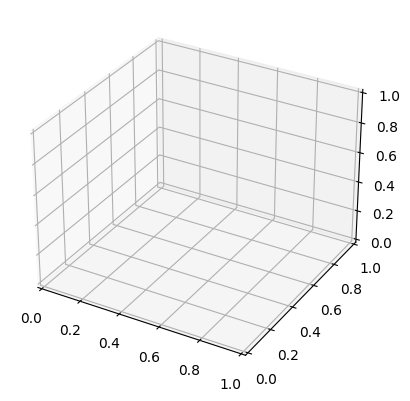

In [4]:
if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # p_start = torch.tensor([0.02, 0.008, 0.054])
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0206, -0.0306, 0.1845],
    #                  dtype=np.float32) # 1
    # [ 2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01 -2.39781477e-01  9.49010349e-01]
    para_init = np.array([0.034, -0.01, 0.536, 0.2, -0.37, 0.6],
                     dtype=np.float32)

    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '.npy'
    # cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    # para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt_np = read_gt_params(cc_specs_path)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = CatheterOptimizeModel(p_start, para_init, img_ref_binary, gpu_or_cpu, img_save_path).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_old/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        print("Gradients BEFORE BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
            else:
                print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        print("Gradients AFTER BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
            else:
                print(f"{name}: No gradient computed")

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        for name, param in catheter_optimize_model.named_parameters():
            print(f"Parameter: {name}, Updated Value: {param.data}")


        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        print("Loss: ", loss.item())


    # # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    # iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    # print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    # fig1 = plt.figure()
    # ax1 = fig1.add_subplot(111)
    # fig1.suptitle('2D Tip Euclidean Distance Loss History')
    # ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    # ax1.set_xlabel('Iterations')
    # ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    # ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    # ax1.set_ylim([0, 80])
    # ax1.grid(True)
    # plt.show()


    # # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    # iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    # fig2 = plt.figure()
    # ax2 = fig2.add_subplot(111)
    # fig2.suptitle('3D Tip Euclidean Distance Loss History')
    # ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    # ax2.set_xlabel('Iterations')
    # ax2.set_ylabel('Euclidean Distance Loss (m)')
    # ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    # ax2.set_ylim([0, 0.05])
    # ax2.grid(True)
    # plt.show()

proj_end_effector_loss_history:  [351.2109920910515, 322.1263036306386, 294.36601354537254, 268.0089093149556, 243.13072569475798, 219.8015844459979, 198.08268318724652, 178.02096591108776, 159.6432570718571, 142.9501652607108, 127.91098584296817, 114.46145213421667, 102.50502607705772, 91.91875481819064, 82.56208255807859, 74.28780790958929, 66.95290233041193, 60.42767194753037, 54.60278841380672, 49.3936465186249, 44.74258711586024, 40.61931350349235, 37.01943791744279, 33.96058635498467, 31.474720092794254, 29.59551171175015, 28.34114050549562, 27.697148684883057, 27.606923205297356, 27.975268294093343, 28.68315271910808, 29.60541687821923, 30.624759935400235, 31.639258760726904, 32.5649714291682, 33.335625174335924, 33.901000935512975, 34.22525659764623, 34.28505712893107, 34.06817721740726, 33.57208729239241, 32.80271502761845, 31.773334340273554, 30.503469385713377, 29.01780995011333, 27.345257679254072, 25.517899826658507, 23.570188050886316, 21.5380436045542, 19.458152735402376

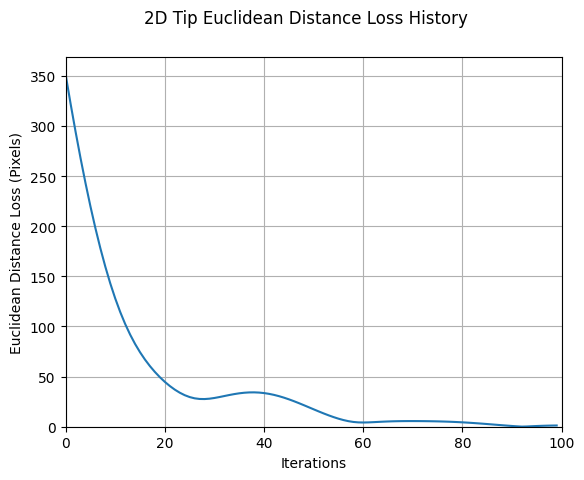

d3d_end_effector_loss_history:  [0.36055800318717957, 0.34738194942474365, 0.33470451831817627, 0.3226074278354645, 0.3111630976200104, 0.3004293739795685, 0.2904455363750458, 0.2812286913394928, 0.272772878408432, 0.26505038142204285, 0.25801563262939453, 0.25161078572273254, 0.24577221274375916, 0.24043665826320648, 0.23554553091526031, 0.23104791343212128, 0.22690171003341675, 0.22307348251342773, 0.21953752636909485, 0.2162744700908661, 0.21326953172683716, 0.21051134169101715, 0.20799040794372559, 0.2056981474161148, 0.20362582802772522, 0.20176398754119873, 0.20010213553905487, 0.19862809777259827, 0.19732829928398132, 0.19618774950504303, 0.19519031047821045, 0.19431929290294647, 0.1935577392578125, 0.19288910925388336, 0.19229790568351746, 0.19177013635635376, 0.1912936568260193, 0.19085870683193207, 0.1904578059911728, 0.19008584320545197, 0.18974007666110992, 0.18941953778266907, 0.18912482261657715, 0.18885765969753265, 0.18862032890319824, 0.1884152740240097, 0.188244596123

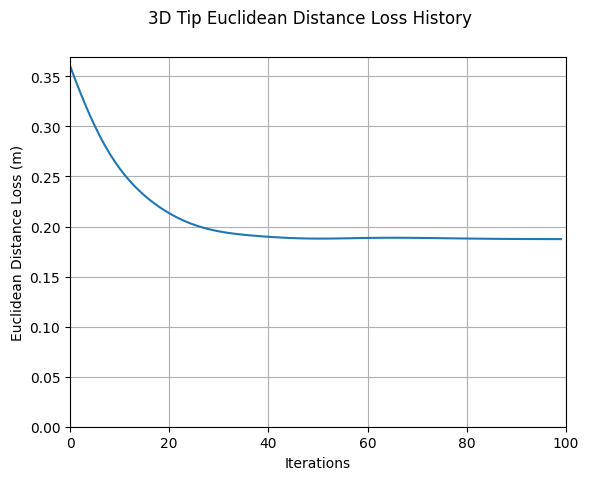

In [5]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.set_ylim(bottom=0)
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
ax2.set_ylim(bottom=0)
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()

In [6]:
p_start_np = p_start.numpy()
result = catheter_optimize_model.para_init.data.cpu().numpy()
control_points = np.vstack([p_start_np, result.reshape(2, 3)])
control_points_gt = np.vstack([p_start_np, para_gt_np.reshape(2, 3)])
control_points_init = np.vstack([p_start_np, para_init.reshape(2, 3)])

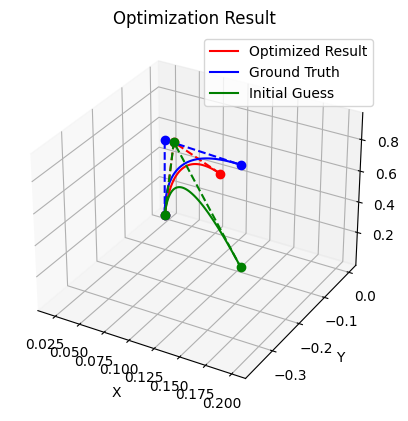

In [7]:
def bezier_curve_3d(control_points, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 3))

    for i in range(num_points):
        curve[i] = (1 - t[i]) ** 2 * control_points[0] + \
                   2 * (1 - t[i]) * t[i] * control_points[1] + \
                   t[i] ** 2 * control_points[2]

    return curve

# Generate the Bezier curve
curve = bezier_curve_3d(control_points)
curve_gt = bezier_curve_3d(control_points_gt)
curve_init = bezier_curve_3d(control_points_init)

# Plotting the Bezier curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制第一条贝塞尔曲线及其控制点
ax.plot(control_points[:, 0], control_points[:, 1], control_points[:, 2], 'ro--')
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], 'r-', label='Optimized Result')

# 绘制第二条贝塞尔曲线及其控制点
ax.plot(control_points_gt[:, 0], control_points_gt[:, 1], control_points_gt[:, 2], 'bo--')
ax.plot(curve_gt[:, 0], curve_gt[:, 1], curve_gt[:, 2], 'b-', label='Ground Truth')

ax.plot(control_points_init[:, 0], control_points_init[:, 1], control_points_init[:, 2], 'go--')
ax.plot(curve_init[:, 0], curve_init[:, 1], curve_init[:, 2], 'g-', label='Initial Guess')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Optimization Result')
ax.legend()

# plt.savefig('Result.png')

plt.show()